In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import rand

In [72]:
def compute_prox(x, mu):
    p = np.zeros(x.size)
    for i in range(x.size):
        if np.abs(x[i]) > mu:
            p[i] = (1 - mu / np.abs(x[i])) * x[i]
    return p

def compute_prox_subgradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 1
        elif np.abs(u[i]) < mu:
            g[i] = 0
        else:
            g[i] = np.random.rand(1)[0]
    return g

def compute_l1_subgradient(u):
    g = np.zeros(u.size)
    for i in range(u.size):
        if u[i] != 0:
            g[i] = np.sign(u[i])
        else:
            g[i] = 2 * np.random.rand(1)[0] - 1
    return g

def compute_subgradient(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_prox_subgradient(output, mu)
    g_1 = np.transpose(D).dot(np.diag(g_1))
    g_1 = g_1.dot(compute_prox(output, mu))
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    
    return g

def update_ellipsoid(z, A, g):
    p = z.size
    den = np.sqrt(g.dot(A.dot(g)))
    g = (1 / den) * g
    A_g = A.dot(g)
    z = z - (1 / (p + 1)) * A_g
    A = (p ** 2 / (p ** 2 - 1)) * (A - (2 / (p + 1)) * np.outer(A_g, A_g))
    
    return z, A

def iterate_ellipsoids(D, y, z_init, A_init, n_steps):
    z = z_init
    A = A_init
    while k < n_steps:
        g = compute_subgradient(z, D, y)
        z, A = update_ellipsoid(z, A, g)
        
    return z, A

def compute_test(D_i, y_i, z, A):
    test_1 = D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))/ 2) - y_i
    test_2 = - D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))/ 2) - y_i

    return test_1, test_2

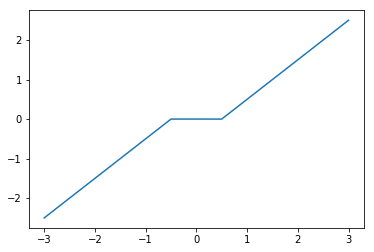

In [73]:
z = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3])
A = np.array([[1,2],[3,4]])
g = np.array([1,2])

D_i = np.array([4,2])
y_i = 1

out = compute_prox(z, 0.5)
out
#update_ellipsoid(z, A, g)
#compute_test(D_i, y_i, z, A)
plt.plot(z, out)
plt.show()

In [79]:
#import data, real and synthetic

def make_data(param_set, noise=True):

    n = param_set[0]
    p = param_set[1]
    sparsity = param_set[2]
    X = np.zeros((n,p))
    y = np.zeros(n)
    true_params = rand(p, 1, density = sparsity).A.ravel()
    sparse_ones = np.zeros(p)
    for i in range(p):
        if true_params[i] != 0:
            sparse_ones[i] = 1
    true_params = 2 * true_params - sparse_ones

    noise_norm = 0

    for i in range(n):
        # sample x in [-1,1]^p box
        x = 2 * np.random.rand(p) - np.ones(p) 
        X[i,:] = x
        y[i] = np.dot(true_params,x)
        if noise:
            w = np.random.randn(1) / 10
            y[i] += w
            noise_norm = np.linalg.norm(w)

    return X, y, true_params, noise_norm

param_set = (100, 10, 0.2)
X, y, _, _ = make_data(param_set)

In [80]:
z_init = np.zeros(100)
A_init = np.identity
z, A = iterate_ellipsoids(X, Y, )

array([[ 0.02213486,  0.23516602,  0.38476004,  0.38714413,  0.25819608,
         0.10036923,  0.39770516, -0.97723999, -0.95558847,  0.66541293],
       [-0.55510351,  0.12893935, -0.19152166, -0.88467317,  0.0226791 ,
        -0.65880877, -0.56319103,  0.4613411 , -0.16777811, -0.54388236],
       [-0.74201405, -0.9681098 , -0.6954444 ,  0.06160504,  0.81812046,
        -0.39282022,  0.27821278, -0.00620009,  0.69439795, -0.94050347],
       [ 0.76806684, -0.19906641,  0.6264965 , -0.2717299 ,  0.06197057,
         0.78519784,  0.10907993, -0.66415175, -0.27751515, -0.96723778],
       [-0.2200342 , -0.69684526,  0.04306834, -0.28987844,  0.57629765,
         0.39091921,  0.66766086, -0.21579103,  0.95968693, -0.22442061],
       [ 0.44159617,  0.77556983, -0.84458766,  0.80716945,  0.8532351 ,
        -0.57508574, -0.45296707, -0.48186067, -0.96048927,  0.31878325],
       [ 0.38564912,  0.93522778, -0.73793739,  0.40233382,  0.28941228,
         0.87079904,  0.57095198, -0.87169938